# Machine Learning Practical: Coursework 3 Part 2 working on CIFAR-100
## Baseline experiments

In [31]:
import os
import time
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
%matplotlib inline

### Experiment 1:  Exploring different activation functions

In [32]:
seed = 24102016 
rng = np.random.RandomState(seed)
train_data = CIFAR100DataProvider('train', batch_size=50, rng=rng)
valid_data = CIFAR100DataProvider('valid', batch_size=50, rng=rng)

#### 1-1. Using ReLU as activation function on CIFAR-100

In [33]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [34]:
#note
train_stats_ex1_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex1_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex1_1['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex1_1['epoch_num'].append(e + 1)
        train_stats_ex1_1['error'].append(running_error)
        train_stats_ex1_1['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex1_1['epoch_num'].append(e + 1)
            valid_stats_ex1_1['error'].append(valid_error)
            valid_stats_ex1_1['acc'].append(valid_accuracy)
            valid_stats_ex1_1['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 8.87s to complete
End of epoch 01: err(train)=4.30 acc(train)=0.06
Epoch 02: 8.92s to complete
End of epoch 02: err(train)=3.89 acc(train)=0.11
Epoch 03: 10.18s to complete
End of epoch 03: err(train)=3.72 acc(train)=0.14
Epoch 04: 8.80s to complete
End of epoch 04: err(train)=3.61 acc(train)=0.16
Epoch 05: 8.76s to complete
End of epoch 05: err(train)=3.53 acc(train)=0.18
                 err(valid)=3.57 acc(valid)=0.16
Epoch 06: 8.96s to complete
End of epoch 06: err(train)=3.46 acc(train)=0.19
Epoch 07: 9.24s to complete
End of epoch 07: err(train)=3.40 acc(train)=0.20
Epoch 08: 10.17s to complete
End of epoch 08: err(train)=3.33 acc(train)=0.21
Epoch 09: 8.51s to complete
End of epoch 09: err(train)=3.28 acc(train)=0.22
Epoch 10: 8.47s to complete
End of epoch 10: err(train)=3.23 acc(train)=0.23
                 err(valid)=3.41 acc(valid)=0.20
Epoch 11: 8.43s to complete
End of epoch 11: err(train)=3.19 acc(train)=0.24
Epoch 12: 8.45s to complete
End of epoch 12: err(trai

#### 1-2. Using logistic sigmoid as activation function on CIFAR-100

In [35]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.sigmoid):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs


train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()



In [36]:
#note
train_stats_ex1_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex1_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex1_2['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex1_2['epoch_num'].append(e + 1)
        train_stats_ex1_2['error'].append(running_error)
        train_stats_ex1_2['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex1_2['epoch_num'].append(e + 1)
            valid_stats_ex1_2['error'].append(valid_error)
            valid_stats_ex1_2['acc'].append(valid_accuracy)
            valid_stats_ex1_2['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 8.32s to complete
End of epoch 01: err(train)=4.64 acc(train)=0.01
Epoch 02: 8.38s to complete
End of epoch 02: err(train)=4.60 acc(train)=0.01
Epoch 03: 8.30s to complete
End of epoch 03: err(train)=4.58 acc(train)=0.02
Epoch 04: 8.35s to complete
End of epoch 04: err(train)=4.52 acc(train)=0.04
Epoch 05: 8.36s to complete
End of epoch 05: err(train)=4.41 acc(train)=0.05
                 err(valid)=4.35 acc(valid)=0.05
Epoch 06: 8.34s to complete
End of epoch 06: err(train)=4.29 acc(train)=0.05
Epoch 07: 8.33s to complete
End of epoch 07: err(train)=4.21 acc(train)=0.06
Epoch 08: 8.35s to complete
End of epoch 08: err(train)=4.15 acc(train)=0.06
Epoch 09: 8.31s to complete
End of epoch 09: err(train)=4.11 acc(train)=0.07
Epoch 10: 8.35s to complete
End of epoch 10: err(train)=4.08 acc(train)=0.07
                 err(valid)=4.07 acc(valid)=0.07
Epoch 11: 8.28s to complete
End of epoch 11: err(train)=4.05 acc(train)=0.07
Epoch 12: 8.36s to complete
End of epoch 12: err(train)

#### 1-3. Using tanh as activation function on CIFAR-100

In [37]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.tanh):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs


train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [38]:
#note
train_stats_ex1_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex1_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex1_3['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex1_3['epoch_num'].append(e + 1)
        train_stats_ex1_3['error'].append(running_error)
        train_stats_ex1_3['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex1_3['epoch_num'].append(e + 1)
            valid_stats_ex1_3['error'].append(valid_error)
            valid_stats_ex1_3['acc'].append(valid_accuracy)
            valid_stats_ex1_3['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 8.20s to complete
End of epoch 01: err(train)=4.23 acc(train)=0.07
Epoch 02: 8.28s to complete
End of epoch 02: err(train)=3.82 acc(train)=0.13
Epoch 03: 8.28s to complete
End of epoch 03: err(train)=3.64 acc(train)=0.16
Epoch 04: 8.27s to complete
End of epoch 04: err(train)=3.54 acc(train)=0.18
Epoch 05: 8.28s to complete
End of epoch 05: err(train)=3.45 acc(train)=0.19
                 err(valid)=3.51 acc(valid)=0.18
Epoch 06: 8.27s to complete
End of epoch 06: err(train)=3.38 acc(train)=0.20
Epoch 07: 8.27s to complete
End of epoch 07: err(train)=3.32 acc(train)=0.22
Epoch 08: 8.28s to complete
End of epoch 08: err(train)=3.27 acc(train)=0.22
Epoch 09: 8.27s to complete
End of epoch 09: err(train)=3.22 acc(train)=0.23
Epoch 10: 8.26s to complete
End of epoch 10: err(train)=3.17 acc(train)=0.24
                 err(valid)=3.33 acc(valid)=0.21
Epoch 11: 8.25s to complete
End of epoch 11: err(train)=3.13 acc(train)=0.25
Epoch 12: 8.28s to complete
End of epoch 12: err(train)

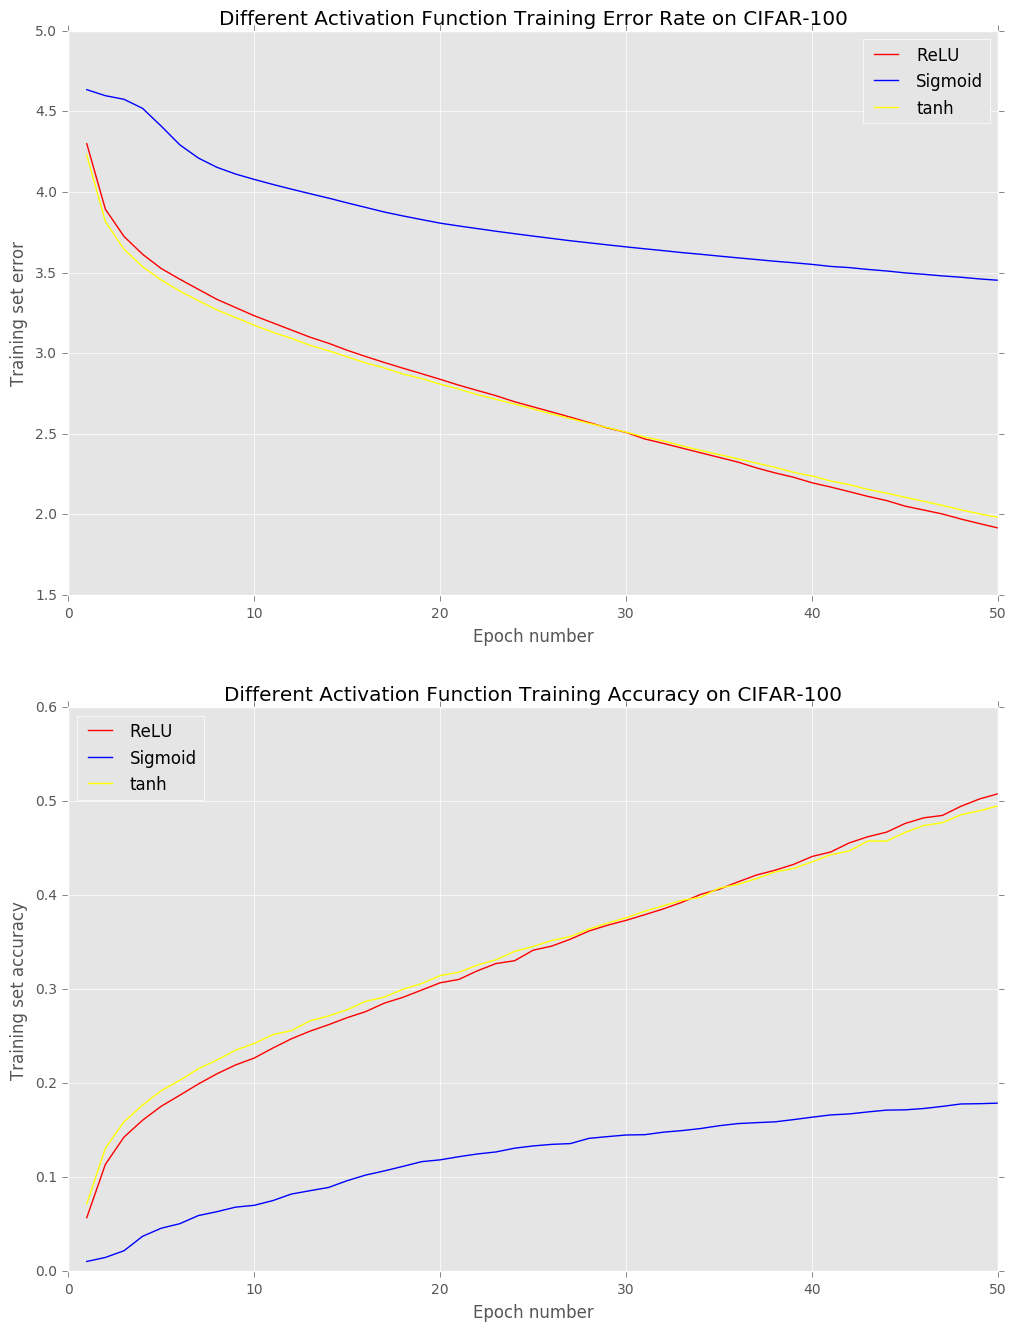

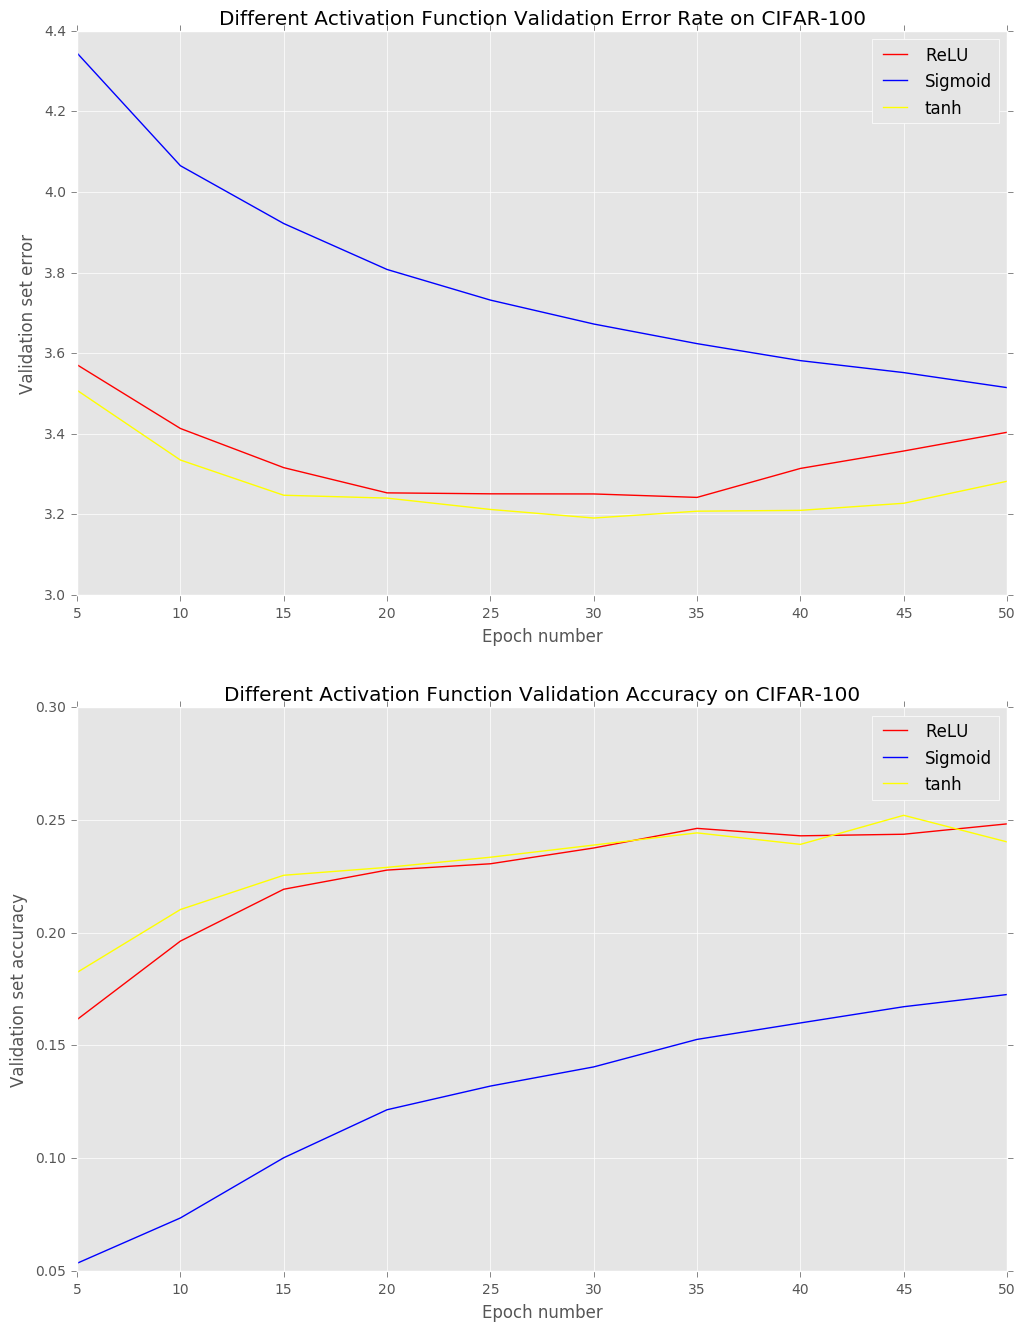

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

colorlist = ['#FF0000','#0000FF', '#FFFF00', '#000000', '#008000', '#800080', '#FFB6C1', '#FFA500']

fig1 = plt.figure(figsize=(12, 16))
ax1 = fig1.add_subplot(2, 1, 1)
ax2 = fig1.add_subplot(2, 1, 2)
ax1.plot(train_stats_ex1_1['epoch_num'], train_stats_ex1_1['error'], label='ReLU', color=colorlist[0])
ax1.plot(train_stats_ex1_2['epoch_num'], train_stats_ex1_2['error'], label='Sigmoid', color=colorlist[1])
ax1.plot(train_stats_ex1_3['epoch_num'], train_stats_ex1_3['error'], label='tanh', color=colorlist[2])

ax2.plot(train_stats_ex1_1['epoch_num'], train_stats_ex1_1['acc'], label='ReLU', color=colorlist[0])
ax2.plot(train_stats_ex1_2['epoch_num'], train_stats_ex1_2['acc'], label='Sigmoid', color=colorlist[1])
ax2.plot(train_stats_ex1_3['epoch_num'], train_stats_ex1_3['acc'], label='tanh', color=colorlist[2])

ax1.set_title('Different Activation Function Training Error Rate on CIFAR-100')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')

ax2.set_title('Different Activation Function Training Accuracy on CIFAR-100')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Training set accuracy')

plt.show()
fig1.tight_layout()
fig1.savefig('ex_1_fig_1-100.pdf')

fig2 = plt.figure(figsize=(12, 16))
ax1 = fig2.add_subplot(2, 1, 1)
ax2 = fig2.add_subplot(2, 1, 2)
ax1.plot(valid_stats_ex1_1['epoch_num'], valid_stats_ex1_1['error'], label='ReLU', color=colorlist[0])
ax1.plot(valid_stats_ex1_2['epoch_num'], valid_stats_ex1_2['error'], label='Sigmoid', color=colorlist[1])
ax1.plot(valid_stats_ex1_3['epoch_num'], valid_stats_ex1_3['error'], label='tanh', color=colorlist[2])

ax2.plot(valid_stats_ex1_1['epoch_num'], valid_stats_ex1_1['acc'], label='ReLU', color=colorlist[0])
ax2.plot(valid_stats_ex1_2['epoch_num'], valid_stats_ex1_2['acc'], label='Sigmoid', color=colorlist[1])
ax2.plot(valid_stats_ex1_3['epoch_num'], valid_stats_ex1_3['acc'], label='tanh', color=colorlist[2])

ax1.set_title('Different Activation Function Validation Error Rate on CIFAR-100')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Validation set error')

ax2.set_title('Different Activation Function Validation Accuracy on CIFAR-100')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')

plt.show()
fig2.tight_layout()
fig2.savefig('ex_1_fig_2-100.pdf')

### Experiment 2:  Exploring different hidden layer depths and widths

In [40]:
seed = 24102016 
rng = np.random.RandomState(seed)
train_data = CIFAR100DataProvider('train', batch_size=50, rng=rng)
valid_data = CIFAR100DataProvider('valid', batch_size=50, rng=rng)

#### 2-1. Using  1 hidden layer and 300 units per layer on CIFAR-100

In [41]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_1, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [42]:
print train_stats_ex3_1#note
train_stats_ex2_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex2_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex2_1['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex2_1['epoch_num'].append(e + 1)
        train_stats_ex2_1['error'].append(running_error)
        train_stats_ex2_1['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex2_1['epoch_num'].append(e + 1)
            valid_stats_ex2_1['error'].append(valid_error)
            valid_stats_ex2_1['acc'].append(valid_accuracy)
            valid_stats_ex2_1['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 7.03s to complete
End of epoch 01: err(train)=4.35 acc(train)=0.05
Epoch 02: 7.06s to complete
End of epoch 02: err(train)=3.98 acc(train)=0.11
Epoch 03: 7.03s to complete
End of epoch 03: err(train)=3.82 acc(train)=0.13
Epoch 04: 7.05s to complete
End of epoch 04: err(train)=3.72 acc(train)=0.15
Epoch 05: 7.00s to complete
End of epoch 05: err(train)=3.65 acc(train)=0.16
                 err(valid)=3.67 acc(valid)=0.16
Epoch 06: 7.07s to complete
End of epoch 06: err(train)=3.58 acc(train)=0.17
Epoch 07: 7.03s to complete
End of epoch 07: err(train)=3.53 acc(train)=0.18
Epoch 08: 7.02s to complete
End of epoch 08: err(train)=3.49 acc(train)=0.19
Epoch 09: 6.99s to complete
End of epoch 09: err(train)=3.44 acc(train)=0.20
Epoch 10: 7.09s to complete
End of epoch 10: err(train)=3.40 acc(train)=0.21
                 err(valid)=3.55 acc(valid)=0.18
Epoch 11: 7.03s to complete
End of epoch 11: err(train)=3.37 acc(train)=0.21
Epoch 12: 7.10s to complete
End of epoch 12: err(train)

#### 2-2. Using  3 hidden layer and 300 units per layer on CIFAR-100

In [43]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [44]:
#note
train_stats_ex2_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex2_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex2_2['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex2_2['epoch_num'].append(e + 1)
        train_stats_ex2_2['error'].append(running_error)
        train_stats_ex2_2['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex2_2['epoch_num'].append(e + 1)
            valid_stats_ex2_2['error'].append(valid_error)
            valid_stats_ex2_2['acc'].append(valid_accuracy)
            valid_stats_ex2_2['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 8.42s to complete
End of epoch 01: err(train)=4.33 acc(train)=0.05
Epoch 02: 8.56s to complete
End of epoch 02: err(train)=3.92 acc(train)=0.10
Epoch 03: 8.48s to complete
End of epoch 03: err(train)=3.75 acc(train)=0.14
Epoch 04: 8.48s to complete
End of epoch 04: err(train)=3.63 acc(train)=0.16
Epoch 05: 8.65s to complete
End of epoch 05: err(train)=3.54 acc(train)=0.17
                 err(valid)=3.59 acc(valid)=0.17
Epoch 06: 8.71s to complete
End of epoch 06: err(train)=3.47 acc(train)=0.18
Epoch 07: 8.65s to complete
End of epoch 07: err(train)=3.41 acc(train)=0.20
Epoch 08: 8.74s to complete
End of epoch 08: err(train)=3.35 acc(train)=0.21
Epoch 09: 8.68s to complete
End of epoch 09: err(train)=3.29 acc(train)=0.22
Epoch 10: 8.78s to complete
End of epoch 10: err(train)=3.25 acc(train)=0.23
                 err(valid)=3.40 acc(valid)=0.20
Epoch 11: 8.53s to complete
End of epoch 11: err(train)=3.20 acc(train)=0.23
Epoch 12: 8.57s to complete
End of epoch 12: err(train)

#### 2-3 Using  5 hidden layer and 300 units per layer on CIFAR-100

In [45]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('fc-layer-4'):
    hidden_4 = fully_connected_layer(hidden_3, num_hidden, num_hidden)
with tf.name_scope('fc-layer-5'):
    hidden_5 = fully_connected_layer(hidden_4, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_5, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [46]:
#note
train_stats_ex2_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex2_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex2_3['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex2_3['epoch_num'].append(e + 1)
        train_stats_ex2_3['error'].append(running_error)
        train_stats_ex2_3['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex2_3['epoch_num'].append(e + 1)
            valid_stats_ex2_3['error'].append(valid_error)
            valid_stats_ex2_3['acc'].append(valid_accuracy)
            valid_stats_ex2_3['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 9.83s to complete
End of epoch 01: err(train)=4.32 acc(train)=0.05
Epoch 02: 9.89s to complete
End of epoch 02: err(train)=3.89 acc(train)=0.11
Epoch 03: 9.85s to complete
End of epoch 03: err(train)=3.70 acc(train)=0.14
Epoch 04: 9.83s to complete
End of epoch 04: err(train)=3.59 acc(train)=0.16
Epoch 05: 9.85s to complete
End of epoch 05: err(train)=3.50 acc(train)=0.18
                 err(valid)=3.55 acc(valid)=0.16
Epoch 06: 9.89s to complete
End of epoch 06: err(train)=3.41 acc(train)=0.19
Epoch 07: 9.90s to complete
End of epoch 07: err(train)=3.34 acc(train)=0.20
Epoch 08: 9.91s to complete
End of epoch 08: err(train)=3.28 acc(train)=0.21
Epoch 09: 10.02s to complete
End of epoch 09: err(train)=3.22 acc(train)=0.23
Epoch 10: 9.90s to complete
End of epoch 10: err(train)=3.16 acc(train)=0.24
                 err(valid)=3.33 acc(valid)=0.21
Epoch 11: 9.87s to complete
End of epoch 11: err(train)=3.11 acc(train)=0.24
Epoch 12: 9.91s to complete
End of epoch 12: err(train

#### 2-4. Using  3 hidden layer and 500 units per layer on CIFAR-100

In [47]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 500

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [48]:
#note
train_stats_ex2_4 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex2_4 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex2_4['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex2_4['epoch_num'].append(e + 1)
        train_stats_ex2_4['error'].append(running_error)
        train_stats_ex2_4['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex2_4['epoch_num'].append(e + 1)
            valid_stats_ex2_4['error'].append(valid_error)
            valid_stats_ex2_4['acc'].append(valid_accuracy)
            valid_stats_ex2_4['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 15.56s to complete
End of epoch 01: err(train)=4.23 acc(train)=0.07
Epoch 02: 15.95s to complete
End of epoch 02: err(train)=3.82 acc(train)=0.13
Epoch 03: 14.10s to complete
End of epoch 03: err(train)=3.64 acc(train)=0.15
Epoch 04: 14.21s to complete
End of epoch 04: err(train)=3.53 acc(train)=0.17
Epoch 05: 14.05s to complete
End of epoch 05: err(train)=3.44 acc(train)=0.19
                 err(valid)=3.51 acc(valid)=0.18
Epoch 06: 14.07s to complete
End of epoch 06: err(train)=3.35 acc(train)=0.20
Epoch 07: 13.86s to complete
End of epoch 07: err(train)=3.28 acc(train)=0.22
Epoch 08: 13.79s to complete
End of epoch 08: err(train)=3.21 acc(train)=0.23
Epoch 09: 14.01s to complete
End of epoch 09: err(train)=3.14 acc(train)=0.24
Epoch 10: 13.84s to complete
End of epoch 10: err(train)=3.08 acc(train)=0.25
                 err(valid)=3.33 acc(valid)=0.21
Epoch 11: 13.85s to complete
End of epoch 11: err(train)=3.03 acc(train)=0.27
Epoch 12: 13.82s to complete
End of epoch 12

#### 2-5. Using  3 hidden layer and 1000 units per layer on CIFAR-100

In [49]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 1000

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [50]:
#note
train_stats_ex2_5 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex2_5 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex2_3['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex2_5['epoch_num'].append(e + 1)
        train_stats_ex2_5['error'].append(running_error)
        train_stats_ex2_5['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex2_5['epoch_num'].append(e + 1)
            valid_stats_ex2_5['error'].append(valid_error)
            valid_stats_ex2_5['acc'].append(valid_accuracy)
            valid_stats_ex2_5['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 28.75s to complete
End of epoch 01: err(train)=4.15 acc(train)=0.08
Epoch 02: 28.98s to complete
End of epoch 02: err(train)=3.73 acc(train)=0.14
Epoch 03: 29.25s to complete
End of epoch 03: err(train)=3.54 acc(train)=0.17
Epoch 04: 28.91s to complete
End of epoch 04: err(train)=3.41 acc(train)=0.20
Epoch 05: 28.95s to complete
End of epoch 05: err(train)=3.30 acc(train)=0.21
                 err(valid)=3.44 acc(valid)=0.19
Epoch 06: 37.61s to complete
End of epoch 06: err(train)=3.20 acc(train)=0.23
Epoch 07: 29.57s to complete
End of epoch 07: err(train)=3.11 acc(train)=0.25
Epoch 08: 29.65s to complete
End of epoch 08: err(train)=3.02 acc(train)=0.27
Epoch 09: 29.49s to complete
End of epoch 09: err(train)=2.94 acc(train)=0.28
Epoch 10: 29.51s to complete
End of epoch 10: err(train)=2.85 acc(train)=0.30
                 err(valid)=3.26 acc(valid)=0.22
Epoch 11: 29.42s to complete
End of epoch 11: err(train)=2.77 acc(train)=0.32
Epoch 12: 29.43s to complete
End of epoch 12

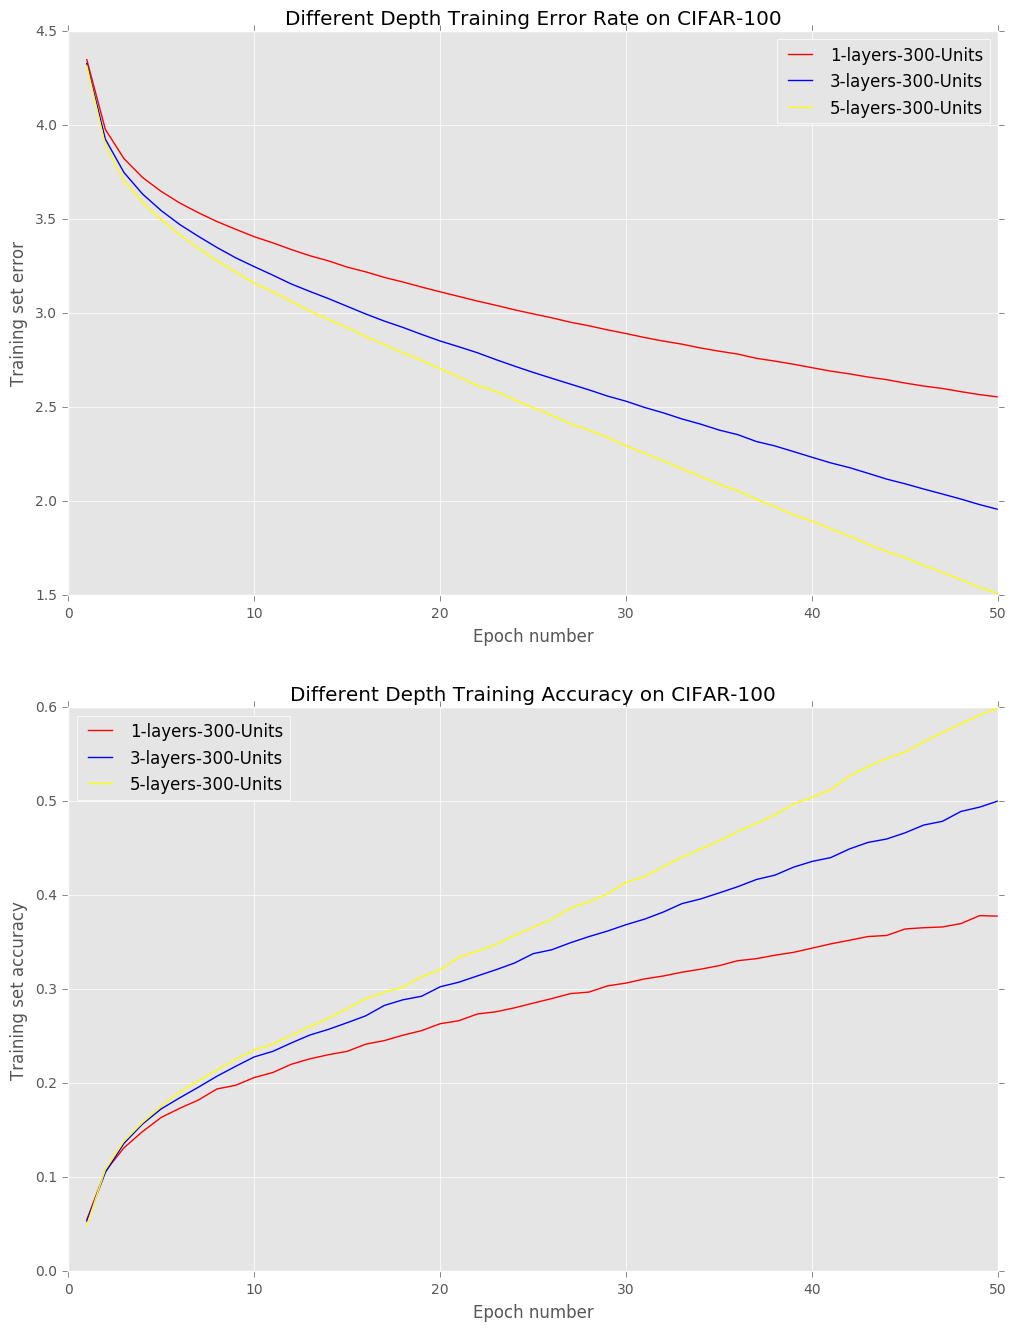

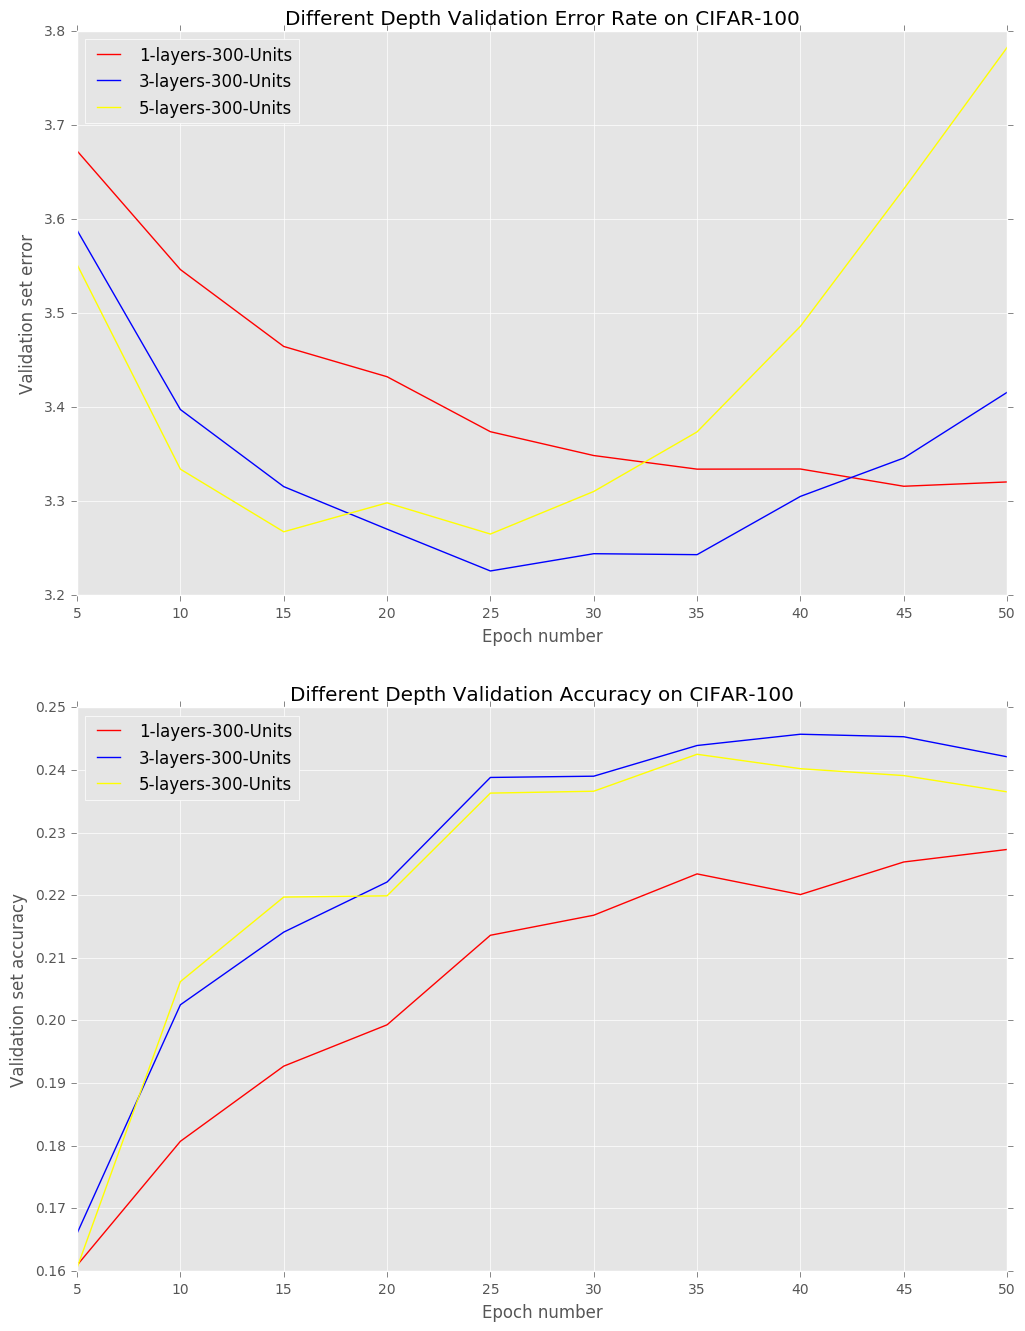

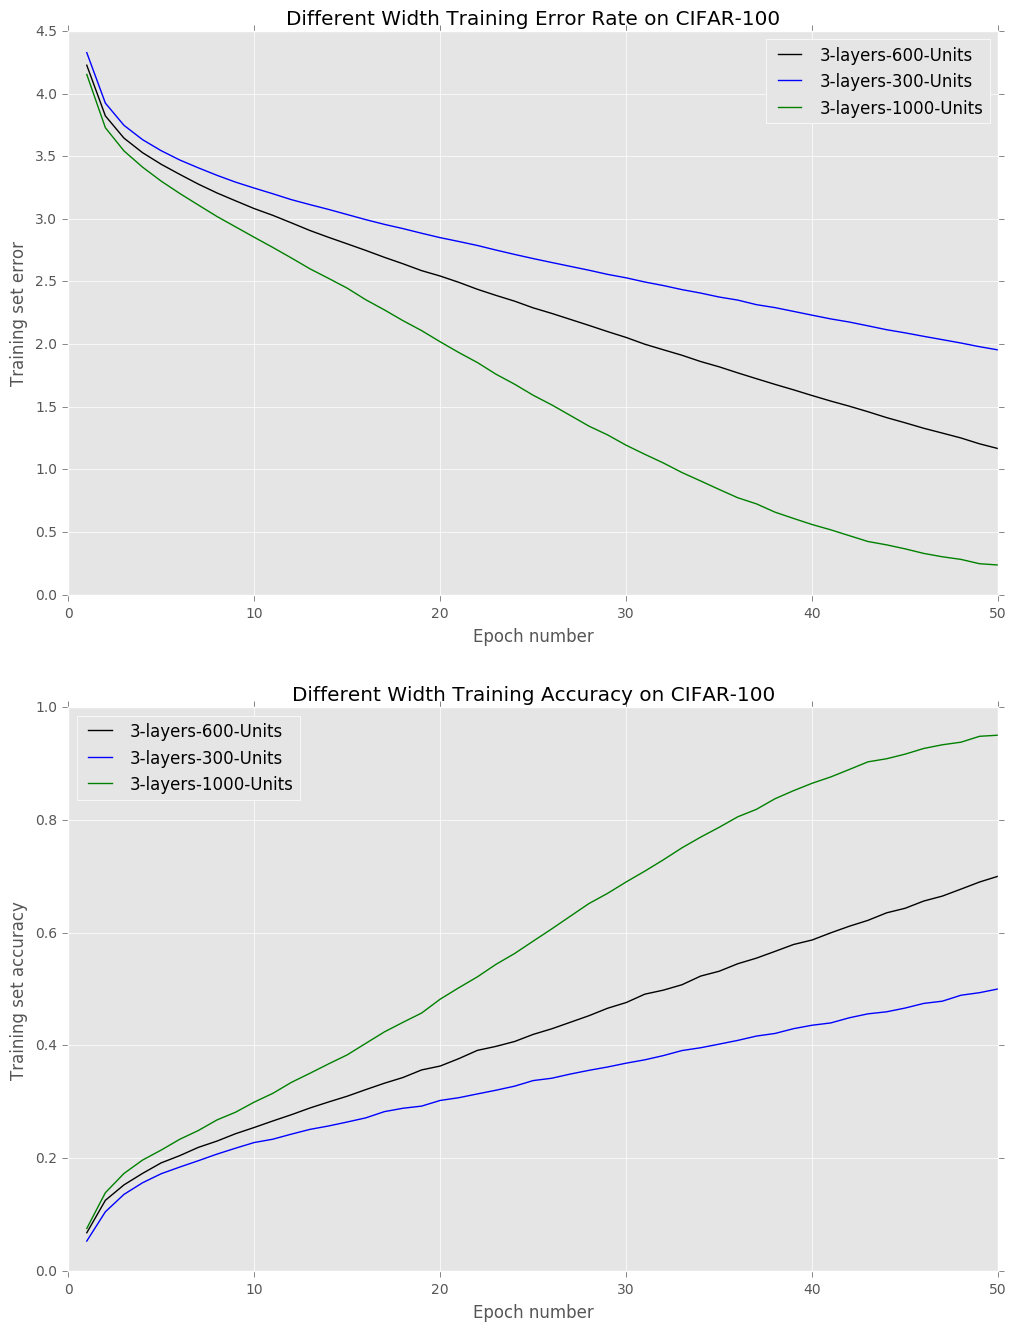

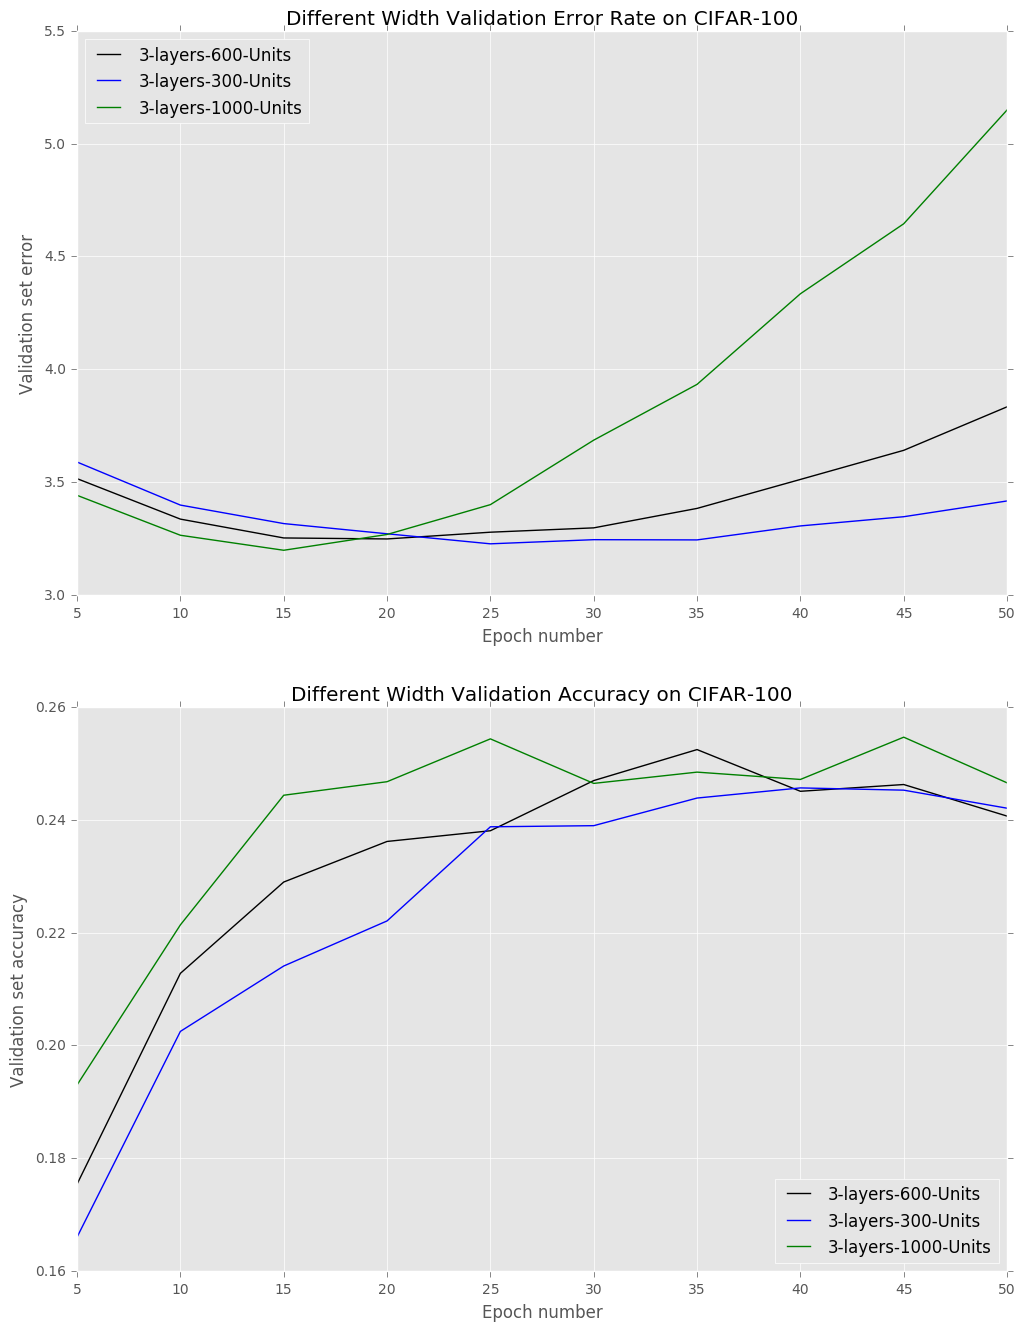

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

colorlist = ['#FF0000','#0000FF', '#FFFF00', '#000000', '#008000', '#800080', '#FFB6C1', '#FFA500']

fig1 = plt.figure(figsize=(12, 16))
ax1 = fig1.add_subplot(2, 1, 1)
ax2 = fig1.add_subplot(2, 1, 2)
ax1.plot(train_stats_ex2_1['epoch_num'], train_stats_ex2_1['error'], label='1-layers-300-Units', color=colorlist[0])
ax1.plot(train_stats_ex2_2['epoch_num'], train_stats_ex2_2['error'], label='3-layers-300-Units', color=colorlist[1])
ax1.plot(train_stats_ex2_3['epoch_num'], train_stats_ex2_3['error'], label='5-layers-300-Units', color=colorlist[2])

ax2.plot(train_stats_ex2_1['epoch_num'], train_stats_ex2_1['acc'], label='1-layers-300-Units', color=colorlist[0])
ax2.plot(train_stats_ex2_2['epoch_num'], train_stats_ex2_2['acc'], label='3-layers-300-Units', color=colorlist[1])
ax2.plot(train_stats_ex2_3['epoch_num'], train_stats_ex2_3['acc'], label='5-layers-300-Units', color=colorlist[2])

ax1.set_title('Different Depth Training Error Rate on CIFAR-100')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')

ax2.set_title('Different Depth Training Accuracy on CIFAR-100')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Training set accuracy')

plt.show()
fig1.tight_layout()
fig1.savefig('ex_2_fig_1-100.pdf')

fig2 = plt.figure(figsize=(12, 16))
ax1 = fig2.add_subplot(2, 1, 1)
ax2 = fig2.add_subplot(2, 1, 2)
ax1.plot(valid_stats_ex2_1['epoch_num'], valid_stats_ex2_1['error'], label='1-layers-300-Units', color=colorlist[0])
ax1.plot(valid_stats_ex2_2['epoch_num'], valid_stats_ex2_2['error'], label='3-layers-300-Units', color=colorlist[1])
ax1.plot(valid_stats_ex2_3['epoch_num'], valid_stats_ex2_3['error'], label='5-layers-300-Units', color=colorlist[2])

ax2.plot(valid_stats_ex2_1['epoch_num'], valid_stats_ex2_1['acc'], label='1-layers-300-Units', color=colorlist[0])
ax2.plot(valid_stats_ex2_2['epoch_num'], valid_stats_ex2_2['acc'], label='3-layers-300-Units', color=colorlist[1])
ax2.plot(valid_stats_ex2_3['epoch_num'], valid_stats_ex2_3['acc'], label='5-layers-300-Units', color=colorlist[2])

ax1.set_title('Different Depth Validation Error Rate on CIFAR-100')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Validation set error')

ax2.set_title('Different Depth Validation Accuracy on CIFAR-100')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')

plt.show()
fig2.tight_layout()
fig2.savefig('ex_2_fig_2-100.pdf')


fig3 = plt.figure(figsize=(12, 16))
ax1 = fig3.add_subplot(2, 1, 1)
ax2 = fig3.add_subplot(2, 1, 2)
ax1.plot(train_stats_ex2_4['epoch_num'], train_stats_ex2_4['error'], label='3-layers-600-Units', color=colorlist[3])
ax1.plot(train_stats_ex2_2['epoch_num'], train_stats_ex2_2['error'], label='3-layers-300-Units', color=colorlist[1])
ax1.plot(train_stats_ex2_5['epoch_num'], train_stats_ex2_5['error'], label='3-layers-1000-Units', color=colorlist[4])

ax2.plot(train_stats_ex2_4['epoch_num'], train_stats_ex2_4['acc'], label='3-layers-600-Units', color=colorlist[3])
ax2.plot(train_stats_ex2_2['epoch_num'], train_stats_ex2_2['acc'], label='3-layers-300-Units', color=colorlist[1])
ax2.plot(train_stats_ex2_5['epoch_num'], train_stats_ex2_5['acc'], label='3-layers-1000-Units', color=colorlist[4])

ax1.set_title('Different Width Training Error Rate on CIFAR-100')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')

ax2.set_title('Different Width Training Accuracy on CIFAR-100')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Training set accuracy')

plt.show()
fig3.tight_layout()
fig3.savefig('ex_2_fig_3-100.pdf')

fig4 = plt.figure(figsize=(12, 16))print train_stats_ex3_1
ax1 = fig4.add_subplot(2, 1, 1)
ax2 = fig4.add_subplot(2, 1, 2)
ax1.plot(valid_stats_ex2_4['epoch_num'], valid_stats_ex2_4['error'], label='3-layers-600-Units', color=colorlist[3])
ax1.plot(valid_stats_ex2_2['epoch_num'], valid_stats_ex2_2['error'], label='3-layers-300-Units', color=colorlist[1])
ax1.plot(valid_stats_ex2_5['epoch_num'], valid_stats_ex2_5['error'], label='3-layers-1000-Units', color=colorlist[4])

ax2.plot(valid_stats_ex2_4['epoch_num'], valid_stats_ex2_4['acc'], label='3-layers-600-Units', color=colorlist[3])
ax2.plot(valid_stats_ex2_2['epoch_num'], valid_stats_ex2_2['acc'], label='3-layers-300-Units', color=colorlist[1])
ax2.plot(valid_stats_ex2_5['epoch_num'], valid_stats_ex2_5['acc'], label='3-layers-1000-Units', color=colorlist[4])

ax1.set_title('Different Width Validation Error Rate on CIFAR-100')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Validation set error')

ax2.set_title('Different Width Validation Accuracy on CIFAR-100')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')

plt.show()
fig4.tight_layout()
fig4.savefig('ex_2_fig_4-100.pdf')

### Experiment 3:  Exploring different regularisation

In [3]:
seed = 24102016 
rng = np.random.RandomState(seed)
train_data = CIFAR100DataProvider('train', batch_size=50, rng=rng)
valid_data = CIFAR100DataProvider('valid', batch_size=50, rng=rng)

#### 3-1. Using  L1 regularisation on CIFAR-100

In [4]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs, weights

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300
beta_l1 = 0.0001

#note
with tf.name_scope('fc-layer-1'):
    hidden_1, weight_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2, weight_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3, weight_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs, weight_4 = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('L1-regularisation'):
    l1_reg = (tf.reduce_sum(tf.abs(weight_1)) + tf.reduce_sum(tf.abs(weight_2))
              + tf.reduce_sum(tf.abs(weight_3)) + tf.reduce_sum(tf.abs(weight_4)))
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets)) + beta_l1 * l1_reg
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [5]:
#note
train_stats_ex3_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex3_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex3_1['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex3_1['epoch_num'].append(e + 1)
        train_stats_ex3_1['error'].append(running_error)
        train_stats_ex3_1['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex3_1['epoch_num'].append(e + 1)
            valid_stats_ex3_1['error'].append(valid_error)
            valid_stats_ex3_1['acc'].append(valid_accuracy)
            valid_stats_ex3_1['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 18.38s to complete
End of epoch 01: err(train)=7.78 acc(train)=0.06
Epoch 02: 18.78s to complete
End of epoch 02: err(train)=7.11 acc(train)=0.11
Epoch 03: 17.01s to complete
End of epoch 03: err(train)=6.67 acc(train)=0.14
Epoch 04: 17.07s to complete
End of epoch 04: err(train)=6.32 acc(train)=0.16
Epoch 05: 16.80s to complete
End of epoch 05: err(train)=6.03 acc(train)=0.17
                 err(valid)=5.96 acc(valid)=0.16
Epoch 06: 16.83s to complete
End of epoch 06: err(train)=5.79 acc(train)=0.18
Epoch 07: 17.09s to complete
End of epoch 07: err(train)=5.57 acc(train)=0.19
Epoch 08: 16.83s to complete
End of epoch 08: err(train)=5.39 acc(train)=0.20
Epoch 09: 16.85s to complete
End of epoch 09: err(train)=5.24 acc(train)=0.20
Epoch 10: 16.89s to complete
End of epoch 10: err(train)=5.10 acc(train)=0.21
                 err(valid)=5.17 acc(valid)=0.19
Epoch 11: 16.95s to complete
End of epoch 11: err(train)=4.99 acc(train)=0.22
Epoch 12: 16.94s to complete
End of epoch 12

#### 3-2. Using  L2 regularisation on CIFAR-100

In [6]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs, weights

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300
beta_l2 = 0.01

#note
with tf.name_scope('fc-layer-1'):
    hidden_1, weight_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2, weight_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3, weight_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs, weight_4 = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('L2-regularisation'):
    l2_reg = tf.nn.l2_loss(weight_1) + tf.nn.l2_loss(weight_2) + tf.nn.l2_loss(weight_3) + tf.nn.l2_loss(weight_4)
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets)) + beta_l2 * l2_reg
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [7]:
#note
train_stats_ex3_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex3_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex3_2['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex3_2['epoch_num'].append(e + 1)
        train_stats_ex3_2['error'].append(running_error)
        train_stats_ex3_2['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex3_2['epoch_num'].append(e + 1)
            valid_stats_ex3_2['error'].append(valid_error)
            valid_stats_ex3_2['acc'].append(valid_accuracy)
            valid_stats_ex3_2['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 9.81s to complete
End of epoch 01: err(train)=12.86 acc(train)=0.05
Epoch 02: 9.79s to complete
End of epoch 02: err(train)=9.62 acc(train)=0.10
Epoch 03: 9.89s to complete
End of epoch 03: err(train)=7.68 acc(train)=0.12
Epoch 04: 9.84s to complete
End of epoch 04: err(train)=6.57 acc(train)=0.14
Epoch 05: 9.85s to complete
End of epoch 05: err(train)=5.91 acc(train)=0.14
                 err(valid)=5.69 acc(valid)=0.14
Epoch 06: 9.81s to complete
End of epoch 06: err(train)=5.48 acc(train)=0.15
Epoch 07: 9.78s to complete
End of epoch 07: err(train)=5.20 acc(train)=0.15
Epoch 08: 9.79s to complete
End of epoch 08: err(train)=4.98 acc(train)=0.16
Epoch 09: 9.87s to complete
End of epoch 09: err(train)=4.82 acc(train)=0.16
Epoch 10: 9.82s to complete
End of epoch 10: err(train)=4.69 acc(train)=0.16
                 err(valid)=4.65 acc(valid)=0.16
Epoch 11: 10.09s to complete
End of epoch 11: err(train)=4.59 acc(train)=0.16
Epoch 12: 10.08s to complete
End of epoch 12: err(tra

#### 3-3. Using  L1 + L2 regularisation on CIFAR-100

In [8]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs, weights

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300
beta_l1 = 0.0001
beta_l2 = 0.01

#note
with tf.name_scope('fc-layer-1'):
    hidden_1, weight_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2, weight_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3, weight_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs, weight_4 = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('L1-regularisation'):
    l1_reg = (tf.reduce_sum(tf.abs(weight_1)) + tf.reduce_sum(tf.abs(weight_2))
              + tf.reduce_sum(tf.abs(weight_3)) + tf.reduce_sum(tf.abs(weight_4)))
with tf.name_scope('L2-regularisation'):
    l2_reg = tf.nn.l2_loss(weight_1) + tf.nn.l2_loss(weight_2) + tf.nn.l2_loss(weight_3) + tf.nn.l2_loss(weight_4)
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets)) + beta_l1 * l1_reg + beta_l2 * l2_reg
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [9]:
#note
train_stats_ex3_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex3_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex3_3['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex3_3['epoch_num'].append(e + 1)
        train_stats_ex3_3['error'].append(running_error)
        train_stats_ex3_3['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex3_3['epoch_num'].append(e + 1)
            valid_stats_ex3_3['error'].append(valid_error)
            valid_stats_ex3_3['acc'].append(valid_accuracy)
            valid_stats_ex3_3['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 17.84s to complete
End of epoch 01: err(train)=15.78 acc(train)=0.05
Epoch 02: 17.85s to complete
End of epoch 02: err(train)=11.28 acc(train)=0.10
Epoch 03: 17.78s to complete
End of epoch 03: err(train)=8.58 acc(train)=0.12
Epoch 04: 17.89s to complete
End of epoch 04: err(train)=7.09 acc(train)=0.13
Epoch 05: 17.91s to complete
End of epoch 05: err(train)=6.25 acc(train)=0.14
                 err(valid)=5.95 acc(valid)=0.14
Epoch 06: 17.93s to complete
End of epoch 06: err(train)=5.74 acc(train)=0.14
Epoch 07: 17.63s to complete
End of epoch 07: err(train)=5.41 acc(train)=0.14
Epoch 08: 17.75s to complete
End of epoch 08: err(train)=5.19 acc(train)=0.14
Epoch 09: 17.76s to complete
End of epoch 09: err(train)=5.02 acc(train)=0.14
Epoch 10: 17.66s to complete
End of epoch 10: err(train)=4.90 acc(train)=0.14
                 err(valid)=4.83 acc(valid)=0.15
Epoch 11: 17.70s to complete
End of epoch 11: err(train)=4.79 acc(train)=0.14
Epoch 12: 17.69s to complete
End of epoch 

#### 3-4. Using  Dropout regularisation on CIFAR-100

In [10]:
def fully_connected_layer(inputs, input_dim, output_dim, keep_prob, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = tf.nn.dropout(nonlinearity(tf.matmul(inputs, weights) + biases), keep_prob)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300
keep_prob = tf.placeholder(tf.float32)

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden, keep_prob)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden, keep_prob)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden, keep_prob)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, keep_prob, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [11]:
#note
train_stats_ex3_4 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex3_4 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch, keep_prob:0.85})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex3_4['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex3_4['epoch_num'].append(e + 1)
        train_stats_ex3_4['error'].append(running_error)
        train_stats_ex3_4['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob:1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex3_4['epoch_num'].append(e + 1)
            valid_stats_ex3_4['error'].append(valid_error)
            valid_stats_ex3_4['acc'].append(valid_accuracy)
            valid_stats_ex3_4['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 9.19s to complete
End of epoch 01: err(train)=4.54 acc(train)=0.02
Epoch 02: 9.20s to complete
End of epoch 02: err(train)=4.31 acc(train)=0.05
Epoch 03: 9.20s to complete
End of epoch 03: err(train)=4.18 acc(train)=0.07
Epoch 04: 9.22s to complete
End of epoch 04: err(train)=4.09 acc(train)=0.09
Epoch 05: 9.23s to complete
End of epoch 05: err(train)=4.01 acc(train)=0.10
                 err(valid)=3.81 acc(valid)=0.14
Epoch 06: 9.22s to complete
End of epoch 06: err(train)=3.96 acc(train)=0.11
Epoch 07: 9.22s to complete
End of epoch 07: err(train)=3.92 acc(train)=0.11
Epoch 08: 9.25s to complete
End of epoch 08: err(train)=3.88 acc(train)=0.12
Epoch 09: 9.29s to complete
End of epoch 09: err(train)=3.84 acc(train)=0.13
Epoch 10: 9.23s to complete
End of epoch 10: err(train)=3.81 acc(train)=0.13
                 err(valid)=3.60 acc(valid)=0.17
Epoch 11: 9.16s to complete
End of epoch 11: err(train)=3.77 acc(train)=0.14
Epoch 12: 9.18s to complete
End of epoch 12: err(train)

#### 3-5. Using  L1 + L2 + Dropout regularisation on CIFAR-100

In [12]:
def fully_connected_layer(inputs, input_dim, output_dim, keep_prob, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = tf.nn.dropout(nonlinearity(tf.matmul(inputs, weights) + biases), keep_prob)
    return outputs, weights

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300
beta_l1 = 0.0001
beta_l2 = 0.01
keep_prob = tf.placeholder(tf.float32)

#note
with tf.name_scope('fc-layer-1'):
    hidden_1, weight_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden, keep_prob)
with tf.name_scope('fc-layer-2'):
    hidden_2, weight_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden, keep_prob)
with tf.name_scope('fc-layer-3'):
    hidden_3, weight_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden, keep_prob)
with tf.name_scope('output-layer'):
    outputs, weight_4 = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, keep_prob, tf.identity)

with tf.name_scope('L1-regularisation'):
    l1_reg = (tf.reduce_sum(tf.abs(weight_1)) + tf.reduce_sum(tf.abs(weight_2))
              + tf.reduce_sum(tf.abs(weight_3)) + tf.reduce_sum(tf.abs(weight_4)))
with tf.name_scope('L2-regularisation'):
    l2_reg = tf.nn.l2_loss(weight_1) + tf.nn.l2_loss(weight_2) + tf.nn.l2_loss(weight_3) + tf.nn.l2_loss(weight_4)
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets)) + beta_l1 * l1_reg + beta_l2 * l2_reg
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [13]:
#note
train_stats_ex3_5 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex3_5 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch, keep_prob:0.85})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex3_5['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex3_5['epoch_num'].append(e + 1)
        train_stats_ex3_5['error'].append(running_error)
        train_stats_ex3_5['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob:1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex3_5['epoch_num'].append(e + 1)
            valid_stats_ex3_5['error'].append(valid_error)
            valid_stats_ex3_5['acc'].append(valid_accuracy)
            valid_stats_ex3_5['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 17.78s to complete
End of epoch 01: err(train)=16.02 acc(train)=0.02
Epoch 02: 18.10s to complete
End of epoch 02: err(train)=11.34 acc(train)=0.05
Epoch 03: 18.02s to complete
End of epoch 03: err(train)=8.34 acc(train)=0.06
Epoch 04: 17.97s to complete
End of epoch 04: err(train)=6.68 acc(train)=0.08
Epoch 05: 18.08s to complete
End of epoch 05: err(train)=5.81 acc(train)=0.08
                 err(valid)=5.40 acc(valid)=0.10
Epoch 06: 18.13s to complete
End of epoch 06: err(train)=5.33 acc(train)=0.08
Epoch 07: 17.75s to complete
End of epoch 07: err(train)=5.05 acc(train)=0.09
Epoch 08: 18.13s to complete
End of epoch 08: err(train)=4.87 acc(train)=0.09
Epoch 09: 17.77s to complete
End of epoch 09: err(train)=4.74 acc(train)=0.09
Epoch 10: 18.12s to complete
End of epoch 10: err(train)=4.66 acc(train)=0.09
                 err(valid)=4.52 acc(valid)=0.11
Epoch 11: 18.03s to complete
End of epoch 11: err(train)=4.60 acc(train)=0.09
Epoch 12: 18.13s to complete
End of epoch 

#### 3-6. Using  no regularisation on CIFAR-100

In [14]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [15]:
#note
train_stats_ex3_6 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex3_6 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex3_6['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex3_6['epoch_num'].append(e + 1)
        train_stats_ex3_6['error'].append(running_error)
        train_stats_ex3_6['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex3_6['epoch_num'].append(e + 1)
            valid_stats_ex3_6['error'].append(valid_error)
            valid_stats_ex3_6['acc'].append(valid_accuracy)
            valid_stats_ex3_6['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 8.59s to complete
End of epoch 01: err(train)=4.33 acc(train)=0.05
Epoch 02: 8.67s to complete
End of epoch 02: err(train)=3.92 acc(train)=0.11
Epoch 03: 8.62s to complete
End of epoch 03: err(train)=3.74 acc(train)=0.14
Epoch 04: 8.58s to complete
End of epoch 04: err(train)=3.63 acc(train)=0.16
Epoch 05: 8.74s to complete
End of epoch 05: err(train)=3.54 acc(train)=0.17
                 err(valid)=3.57 acc(valid)=0.17
Epoch 06: 8.66s to complete
End of epoch 06: err(train)=3.46 acc(train)=0.19
Epoch 07: 8.70s to complete
End of epoch 07: err(train)=3.40 acc(train)=0.20
Epoch 08: 8.66s to complete
End of epoch 08: err(train)=3.34 acc(train)=0.21
Epoch 09: 8.64s to complete
End of epoch 09: err(train)=3.29 acc(train)=0.22
Epoch 10: 8.70s to complete
End of epoch 10: err(train)=3.24 acc(train)=0.23
                 err(valid)=3.40 acc(valid)=0.20
Epoch 11: 8.63s to complete
End of epoch 11: err(train)=3.19 acc(train)=0.24
Epoch 12: 8.56s to complete
End of epoch 12: err(train)

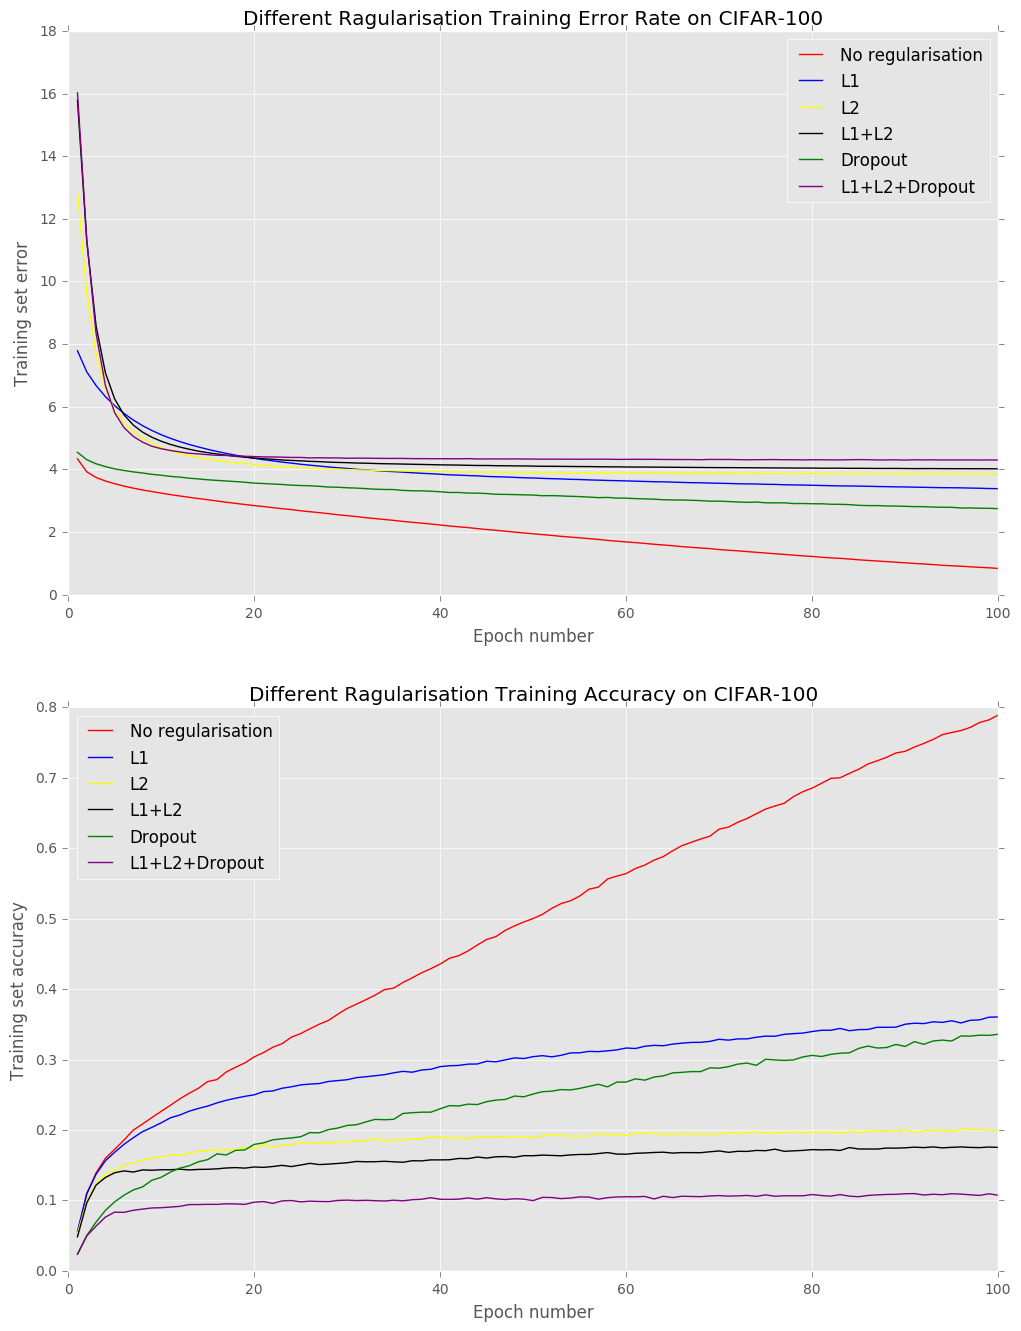

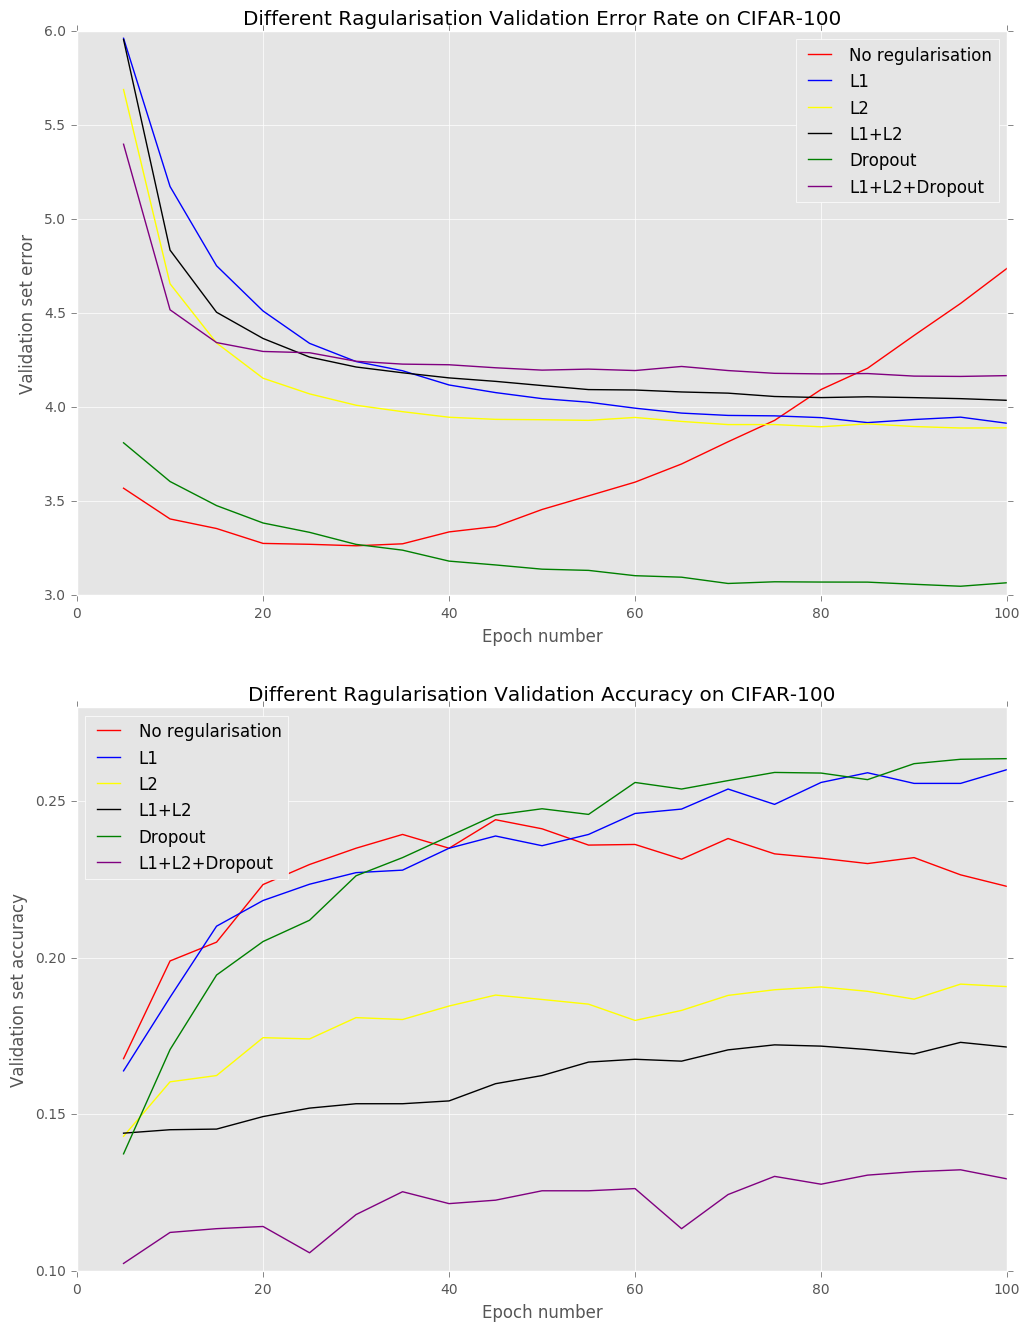

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

colorlist = ['#FF0000','#0000FF', '#FFFF00', '#000000', '#008000', '#800080', '#FFB6C1', '#FFA500']

fig1 = plt.figure(figsize=(12, 16))
ax1 = fig1.add_subplot(2, 1, 1)
ax2 = fig1.add_subplot(2, 1, 2)
ax1.plot(train_stats_ex3_6['epoch_num'], train_stats_ex3_6['error'], label='No regularisation', color=colorlist[0])
ax1.plot(train_stats_ex3_1['epoch_num'], train_stats_ex3_1['error'], label='L1', color=colorlist[1])
ax1.plot(train_stats_ex3_2['epoch_num'], train_stats_ex3_2['error'], label='L2', color=colorlist[2])
ax1.plot(train_stats_ex3_3['epoch_num'], train_stats_ex3_3['error'], label='L1+L2', color=colorlist[3])
ax1.plot(train_stats_ex3_4['epoch_num'], train_stats_ex3_4['error'], label='Dropout', color=colorlist[4])
ax1.plot(train_stats_ex3_5['epoch_num'], train_stats_ex3_5['error'], label='L1+L2+Dropout', color=colorlist[5])

ax2.plot(train_stats_ex3_6['epoch_num'], train_stats_ex3_6['acc'], label='No regularisation', color=colorlist[0])
ax2.plot(train_stats_ex3_1['epoch_num'], train_stats_ex3_1['acc'], label='L1', color=colorlist[1])
ax2.plot(train_stats_ex3_2['epoch_num'], train_stats_ex3_2['acc'], label='L2', color=colorlist[2])
ax2.plot(train_stats_ex3_3['epoch_num'], train_stats_ex3_3['acc'], label='L1+L2', color=colorlist[3])
ax2.plot(train_stats_ex3_4['epoch_num'], train_stats_ex3_4['acc'], label='Dropout', color=colorlist[4])
ax2.plot(train_stats_ex3_5['epoch_num'], train_stats_ex3_5['acc'], label='L1+L2+Dropout', color=colorlist[5])

ax1.set_title('Different Ragularisation Training Error Rate on CIFAR-100')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')

ax2.set_title('Different Ragularisation Training Accuracy on CIFAR-100')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Training set accuracy')

plt.show()
fig1.tight_layout()
fig1.savefig('ex_3_fig_1.pdf')

fig2 = plt.figure(figsize=(12, 16))
ax1 = fig2.add_subplot(2, 1, 1)
ax2 = fig2.add_subplot(2, 1, 2)
ax1.plot(valid_stats_ex3_6['epoch_num'], valid_stats_ex3_6['error'], label='No regularisation', color=colorlist[0])
ax1.plot(valid_stats_ex3_1['epoch_num'], valid_stats_ex3_1['error'], label='L1', color=colorlist[1])
ax1.plot(valid_stats_ex3_2['epoch_num'], valid_stats_ex3_2['error'], label='L2', color=colorlist[2])
ax1.plot(valid_stats_ex3_3['epoch_num'], valid_stats_ex3_3['error'], label='L1+L2', color=colorlist[3])
ax1.plot(valid_stats_ex3_4['epoch_num'], valid_stats_ex3_4['error'], label='Dropout', color=colorlist[4])
ax1.plot(valid_stats_ex3_5['epoch_num'], valid_stats_ex3_5['error'], label='L1+L2+Dropout', color=colorlist[5])

ax2.plot(valid_stats_ex3_6['epoch_num'], valid_stats_ex3_6['acc'], label='No regularisation', color=colorlist[0])
ax2.plot(valid_stats_ex3_1['epoch_num'], valid_stats_ex3_1['acc'], label='L1', color=colorlist[1])
ax2.plot(valid_stats_ex3_2['epoch_num'], valid_stats_ex3_2['acc'], label='L2', color=colorlist[2])
ax2.plot(valid_stats_ex3_3['epoch_num'], valid_stats_ex3_3['acc'], label='L1+L2', color=colorlist[3])
ax2.plot(valid_stats_ex3_4['epoch_num'], valid_stats_ex3_4['acc'], label='Dropout', color=colorlist[4])
ax2.plot(valid_stats_ex3_5['epoch_num'], valid_stats_ex3_5['acc'], label='L1+L2+Dropout', color=colorlist[5])

ax1.set_title('Different Ragularisation Validation Error Rate on CIFAR-100')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Validation set error')

ax2.set_title('Different Ragularisation Validation Accuracy on CIFAR-100')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')

plt.show()
fig2.tight_layout()
fig2.savefig('ex_3_fig_2.pdf')

### Experiment 4:  Exploring different learning rate schedules

In [17]:
seed = 24102016 
rng = np.random.RandomState(seed)
train_data = CIFAR100DataProvider('train', batch_size=50, rng=rng)
valid_data = CIFAR100DataProvider('valid', batch_size=50, rng=rng)

#### 4-1. Using  no learning rate schedules with GradientDescentOptimizeron CIFAR-100

In [18]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate = 0.01).minimize(error)
    
init = tf.global_variables_initializer()

In [19]:
#note
train_stats_ex4_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex4_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex4_1['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex4_1['epoch_num'].append(e + 1)
        train_stats_ex4_1['error'].append(running_error)
        train_stats_ex4_1['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex4_1['epoch_num'].append(e + 1)
            valid_stats_ex4_1['error'].append(valid_error)
            valid_stats_ex4_1['acc'].append(valid_accuracy)
            valid_stats_ex4_1['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 7.17s to complete
End of epoch 01: err(train)=4.33 acc(train)=0.05
Epoch 02: 7.07s to complete
End of epoch 02: err(train)=3.96 acc(train)=0.10
Epoch 03: 7.00s to complete
End of epoch 03: err(train)=3.79 acc(train)=0.13
Epoch 04: 7.15s to complete
End of epoch 04: err(train)=3.68 acc(train)=0.15
Epoch 05: 7.02s to complete
End of epoch 05: err(train)=3.60 acc(train)=0.16
                 err(valid)=3.65 acc(valid)=0.15
Epoch 06: 6.98s to complete
End of epoch 06: err(train)=3.53 acc(train)=0.17
Epoch 07: 6.95s to complete
End of epoch 07: err(train)=3.47 acc(train)=0.18
Epoch 08: 7.03s to complete
End of epoch 08: err(train)=3.41 acc(train)=0.19
Epoch 09: 6.92s to complete
End of epoch 09: err(train)=3.36 acc(train)=0.20
Epoch 10: 7.01s to complete
End of epoch 10: err(train)=3.32 acc(train)=0.21
                 err(valid)=3.44 acc(valid)=0.19
Epoch 11: 7.04s to complete
End of epoch 11: err(train)=3.28 acc(train)=0.22
Epoch 12: 7.00s to complete
End of epoch 12: err(train)

#### 4-2. Using exponential decay to learning rate with GradientDescentOptimizeron on CIFAR-10

In [20]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('learning-rate-schedules'):
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.01
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           10000, 0.96, staircase=True)
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(error)
    
init = tf.global_variables_initializer()

In [21]:
#note
train_stats_ex4_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex4_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex4_2['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex4_2['epoch_num'].append(e + 1)
        train_stats_ex4_2['error'].append(running_error)
        train_stats_ex4_2['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex4_2['epoch_num'].append(e + 1)
            valid_stats_ex4_2['error'].append(valid_error)
            valid_stats_ex4_2['acc'].append(valid_accuracy)
            valid_stats_ex4_2['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 6.93s to complete
End of epoch 01: err(train)=4.34 acc(train)=0.04
Epoch 02: 6.96s to complete
End of epoch 02: err(train)=3.96 acc(train)=0.10
Epoch 03: 6.95s to complete
End of epoch 03: err(train)=3.79 acc(train)=0.13
Epoch 04: 6.98s to complete
End of epoch 04: err(train)=3.68 acc(train)=0.15
Epoch 05: 6.99s to complete
End of epoch 05: err(train)=3.60 acc(train)=0.16
                 err(valid)=3.64 acc(valid)=0.16
Epoch 06: 6.98s to complete
End of epoch 06: err(train)=3.53 acc(train)=0.18
Epoch 07: 6.92s to complete
End of epoch 07: err(train)=3.47 acc(train)=0.18
Epoch 08: 6.90s to complete
End of epoch 08: err(train)=3.42 acc(train)=0.19
Epoch 09: 7.01s to complete
End of epoch 09: err(train)=3.37 acc(train)=0.20
Epoch 10: 6.98s to complete
End of epoch 10: err(train)=3.32 acc(train)=0.21
                 err(valid)=3.41 acc(valid)=0.20
Epoch 11: 7.08s to complete
End of epoch 11: err(train)=3.28 acc(train)=0.22
Epoch 12: 7.03s to complete
End of epoch 12: err(train)

#### 4-3. Using inverse time decay to learning rate with GradientDescentOptimizeron on CIFAR-10

In [23]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('learning-rate-schedules'):
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.01
    k = 0.5
    learning_rate = tf.train.inverse_time_decay(starter_learning_rate, global_step, 10000, k)
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(error)
    
init = tf.global_variables_initializer()

In [24]:
#note
train_stats_ex4_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex4_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex4_3['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex4_3['epoch_num'].append(e + 1)
        train_stats_ex4_3['error'].append(running_error)
        train_stats_ex4_3['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex4_3['epoch_num'].append(e + 1)
            valid_stats_ex4_3['error'].append(valid_error)
            valid_stats_ex4_3['acc'].append(valid_accuracy)
            valid_stats_ex4_3['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 8.09s to complete
End of epoch 01: err(train)=4.35 acc(train)=0.05
Epoch 02: 8.21s to complete
End of epoch 02: err(train)=3.97 acc(train)=0.10
Epoch 03: 8.31s to complete
End of epoch 03: err(train)=3.79 acc(train)=0.13
Epoch 04: 7.15s to complete
End of epoch 04: err(train)=3.68 acc(train)=0.15
Epoch 05: 7.16s to complete
End of epoch 05: err(train)=3.59 acc(train)=0.16
                 err(valid)=3.59 acc(valid)=0.17
Epoch 06: 7.17s to complete
End of epoch 06: err(train)=3.52 acc(train)=0.17
Epoch 07: 7.15s to complete
End of epoch 07: err(train)=3.46 acc(train)=0.19
Epoch 08: 7.18s to complete
End of epoch 08: err(train)=3.40 acc(train)=0.20
Epoch 09: 7.14s to complete
End of epoch 09: err(train)=3.35 acc(train)=0.20
Epoch 10: 7.18s to complete
End of epoch 10: err(train)=3.31 acc(train)=0.21
                 err(valid)=3.42 acc(valid)=0.19
Epoch 11: 7.26s to complete
End of epoch 11: err(train)=3.26 acc(train)=0.22
Epoch 12: 7.19s to complete
End of epoch 12: err(train)

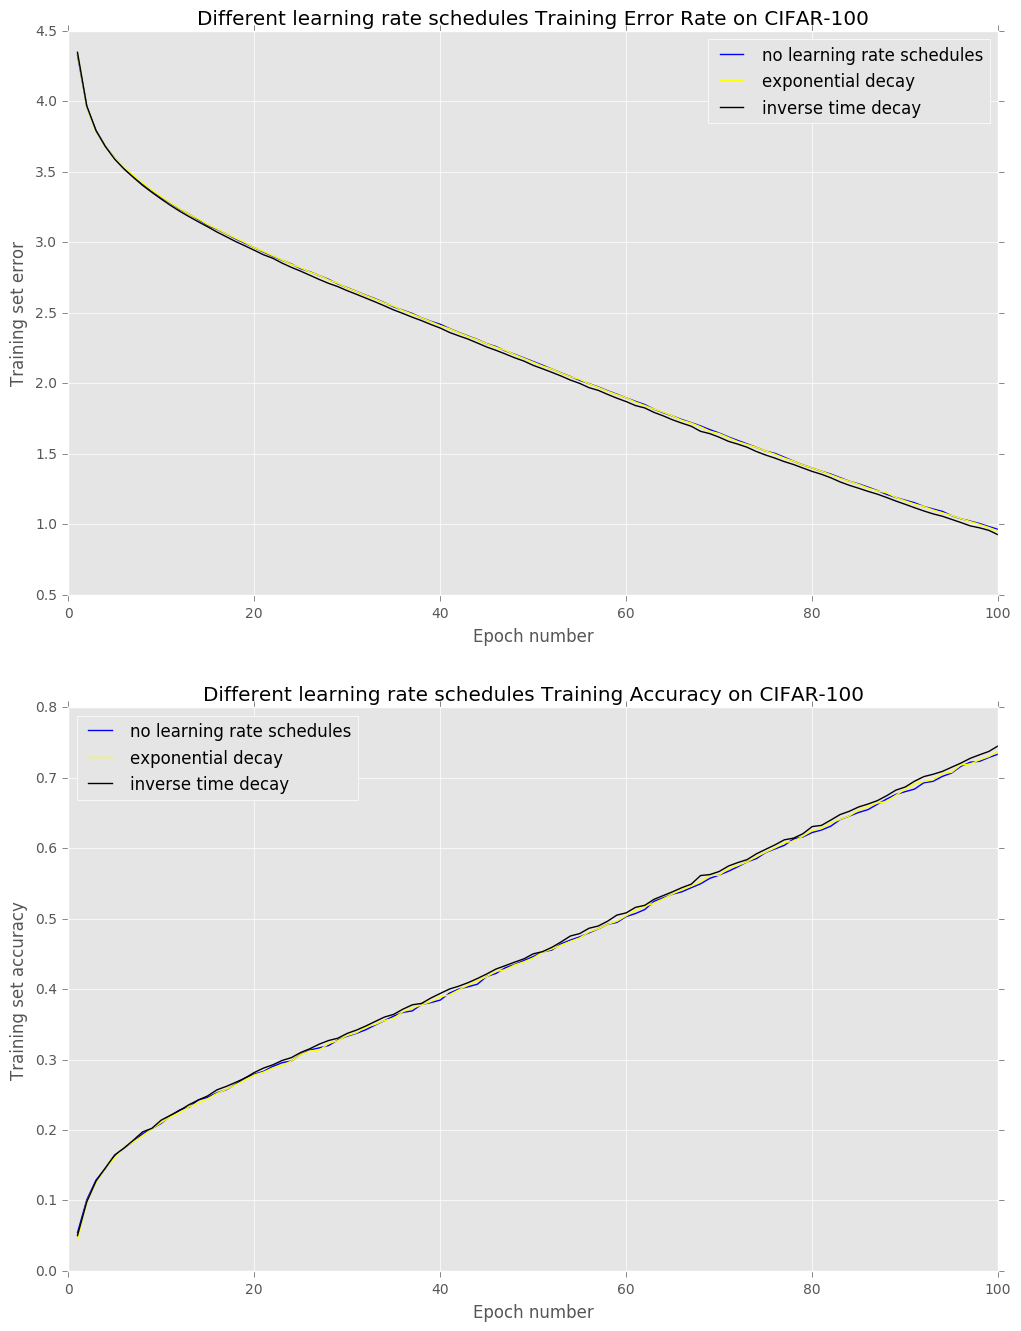

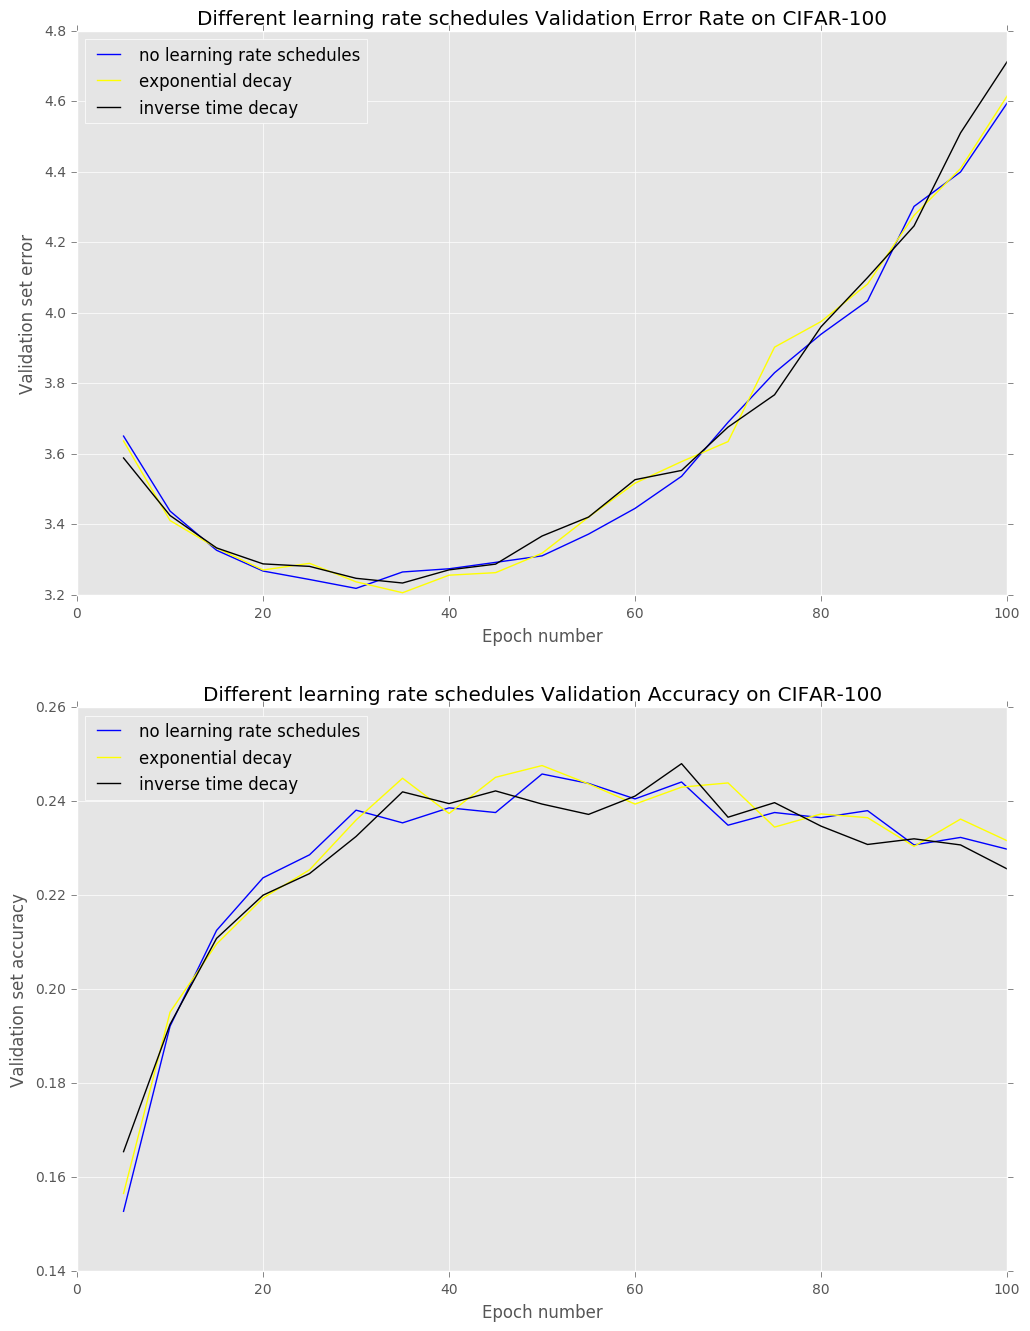

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

colorlist = ['#FF0000','#0000FF', '#FFFF00', '#000000', '#008000', '#800080', '#FFB6C1', '#FFA500']

fig1 = plt.figure(figsize=(12, 16))
ax1 = fig1.add_subplot(2, 1, 1)
ax2 = fig1.add_subplot(2, 1, 2)

ax1.plot(train_stats_ex4_1['epoch_num'], train_stats_ex4_1['error'], label='no learning rate schedules', color=colorlist[1])
ax1.plot(train_stats_ex4_2['epoch_num'], train_stats_ex4_2['error'], label='exponential decay', color=colorlist[2])
ax1.plot(train_stats_ex4_3['epoch_num'], train_stats_ex4_3['error'], label='inverse time decay', color=colorlist[3])

ax2.plot(train_stats_ex4_1['epoch_num'], train_stats_ex4_1['acc'], label='no learning rate schedules', color=colorlist[1])
ax2.plot(train_stats_ex4_2['epoch_num'], train_stats_ex4_2['acc'], label='exponential decay', color=colorlist[2])
ax2.plot(train_stats_ex4_3['epoch_num'], train_stats_ex4_3['acc'], label='inverse time decay', color=colorlist[3])

ax1.set_title('Different learning rate schedules Training Error Rate on CIFAR-100')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')

ax2.set_title('Different learning rate schedules Training Accuracy on CIFAR-100')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Training set accuracy')

plt.show()
fig1.tight_layout()
fig1.savefig('ex_4_fig_1.pdf')

fig2 = plt.figure(figsize=(12, 16))
ax1 = fig2.add_subplot(2, 1, 1)
ax2 = fig2.add_subplot(2, 1, 2)
ax1.plot(valid_stats_ex4_1['epoch_num'], valid_stats_ex4_1['error'], label='no learning rate schedules', color=colorlist[1])
ax1.plot(valid_stats_ex4_2['epoch_num'], valid_stats_ex4_2['error'], label='exponential decay', color=colorlist[2])
ax1.plot(valid_stats_ex4_3['epoch_num'], valid_stats_ex4_3['error'], label='inverse time decay', color=colorlist[3])

ax2.plot(valid_stats_ex4_1['epoch_num'], valid_stats_ex4_1['acc'], label='no learning rate schedules', color=colorlist[1])
ax2.plot(valid_stats_ex4_2['epoch_num'], valid_stats_ex4_2['acc'], label='exponential decay', color=colorlist[2])
ax2.plot(valid_stats_ex4_3['epoch_num'], valid_stats_ex4_3['acc'], label='inverse time decay', color=colorlist[3])

ax1.set_title('Different learning rate schedules Validation Error Rate on CIFAR-100')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Validation set error')

ax2.set_title('Different learning rate schedules Validation Accuracy on CIFAR-100')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')

plt.show()
fig2.tight_layout()
fig2.savefig('ex_4_fig_2.pdf')